<table><tr>
<td>
    <img src="https://raw.githubusercontent.com/maikia/fl_workshop/eff132c0572d437175ac14661b6a5dfd37b4d906/figs/owkin.jpeg" width="100px" /> 
</td>
<td> 
    <img src="https://raw.githubusercontent.com/maikia/fl_workshop/main/figs/substra-logo.svg" width="100px" /> </td>
<td> 
    <img src="https://raw.githubusercontent.com/maikia/fl_workshop/main/figs/pylady_simple_paris_2.png" width="100px" />
</td>
</tr>
    <tr><td>Owkin</td><td>Substra</td><td>Pyladies Paris</td></table>

# Introduction to Federated Learning (FL)<a class="anchor" id="fl"></a>

**author**: [Maria Telenczuk](https://github.com/maikia)

This work is based and inspired by existing resources especially on [`phe` example](https://github.com/data61/python-paillier/blob/master/examples/federated_learning_with_encryption.py) has been reused. Please refer to [Resources](#resources) section.

**Federated learning** is a technique used in machine learning to preserve the security of the data stored in different physical locations (further also refered to as sites or clients). The data nor any information on the data may ever leave the site. At the same time the machine learning models use the data stored on all sites for training. 

This is an introductory workshop in which, together, we will get a better understanding on how FL works and create a simple FL setup. This said, if you have any comments on how to improve or find any bugs please consider filing an issue or submitting a PR.

If you consider working in Federated Learning setting consider using [Substra](https://doc.substra.ai/) for your FL projects. Substra is a framework offering distributed orchestration of machine learning tasks among partners while guaranteeing secure and trustless traceability of all operations.


## Table of Contents:
* [Introduction to Federated Learning (FL)](#fl)
    * [Getting started](#get-started)
    * [Let's speak data](#data)
* [Resources](#resources)

## Getting Started <a class="anchor" id="get-started"></a>

1. Previous experience with `Python` is required. Understanding general machine learning concepts is advisable
1. We will be using `Jupyter` (`jupyter notebook` or `jupyter lab` will work just fine). For a quick intro refer to: [Introduction to Jupyter](jupyter_intro.ipynb)

1. You will also need to have installed few additional libraries: `scikit-learn`, `phe`, `numpy` and `matplotlib`.
    If you don't have them already installed you can do so (using `pip`) by executing the line below:

In [22]:
# install
!{sys.executable} -m pip install numpy matplotlib phe sklearn

## Let's speak data <a class="anchor" id="data"></a>

If you already have some experience with machine learning you know the importance of the data. Here, we are talking about very sensitive data. Let's imagine few use cases:

- mobile phones: use the data from messages on mobile phones towards better text complition. There is only a little data on each phone but it might be very sensitive, therefore it should never leave the phone for the training.
- medical data (hospitals): very sensitive data. Training may potentially benefit from adding more data
- pharmaceutical companies: precious and often expensive to gather data

We will work on diabetics dataset. This is open dataset which is available from [`Scikit-learn`](https://scikit-learn.org/stable/datasets/toy_dataset.html#diabetes-dataset) but let's imagine that this is very sensitive dataset for the needs of this workshop:

### Imports
First, we need to import all the necessary libraries

In [100]:
import matplotlib.pylab as plt
import numpy as np
from sklearn.datasets import load_diabetes
from sklearn.metrics import mean_squared_error

import phe as paillier

seed = 42
np.random.seed(seed)

%matplotlib inline

### Understand the data

In [37]:
diabetes = load_diabetes()
y = diabetes.target
X = diabetes.data

print(f'Data consists of {len(X)} diabetes patients')
print(f'and {X.shape[1]} baseline variables:')
print('age, sex, body mass index, average blood pressure, and six blood serum measurements')

Data consists of 442 diabetes patients
and 10 baseline variables:
age, sex, body mass index, average blood pressure, and six blood serum measurements


Target column is a quantitative measure of disease progression one year after baseline

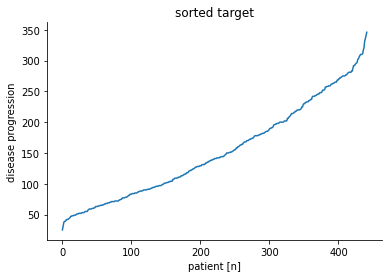

In [81]:
def plot_target(ax, y):
    y_sorted = np.argsort(y)

    ax.set_title('sorted target')
    ax.plot(y[y_sorted])
    ax.set_ylabel('disease progression')
    ax.set_xlabel('patient [n]')

    # Hide the right and top spines
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
ax = plt.subplot(111)
plot_target(ax, y)

In [80]:
# split to test and train datasets
test_size = 50
test_idx = np.random.choice(X.shape[0], size=test_size, replace=False)
train_idx = np.ones(X.shape[0], dtype=bool)
train_idx[test_idx] = False
X_test, y_test = X[test_idx, :], y[test_idx]
X_train, y_train = X[train_idx, :], y[train_idx]

### train the model

To solve the problem we will use Linear Regression. We will start from preparing a class Client which we will later update for our FL setting

In [131]:
class Client:
    """
    Client using linear regression to fit the data
    """
    def __init__(self, name):
        self.name = name
        self.weights = np.zeros(X.shape[1])
    
    def fit(self, X, y, n_iter, eta=0.01):
        """Linear regression for n_iter"""
        for _ in range(n_iter):
            gradient = self.compute_gradient(X, y)
            self.gradient_step(gradient, eta)
    
    def compute_gradient(self, X, y):
        """Compute the gradient of the current model using the training set
        """
        delta = self.predict(X) - y
        return delta.dot(X) / len(X)

    def gradient_step(self, gradient, eta=0.01):
        """Update the model with the given gradient"""
        self.weights -= eta * gradient

    def predict(self, X):
        """Score test data"""
        return X.dot(self.weights)

n_iter = 50
c = Client(name="Hospital")
c.fit(X_train, y_train, n_iter=n_iter, eta=1.5)
y_pred = c.predict(X_test)

We will use mean square error (mse) from sklearn to score the results:

In [132]:
mse = mean_square_error(y_pred, y_test)
print('{:s}:\t{:.2f}'.format(c.name, mse))

Hospital:	26240.48


This is what we would do if we just wanted to train the data of the Client on Linear Regression. Now we will split the data to multiple locations:

In [136]:
# note: this and most of the following functions are reused from phe example cited above
def get_data(n_clients):
    """
    Import the dataset via sklearn, shuffle and split train/test.
    Return training, target lists for `n_clients` and a holdout test set
    """
    print("Loading data")
    diabetes = load_diabetes()
    y = diabetes.target
    X = diabetes.data
    # Add constant to emulate intercept
    X = np.c_[X, np.ones(X.shape[0])]

    # The features are already preprocessed
    # Shuffle
    perm = np.random.permutation(X.shape[0])
    X, y = X[perm, :], y[perm]

    # Select test at random
    test_size = 50
    test_idx = np.random.choice(X.shape[0], size=test_size, replace=False)
    train_idx = np.ones(X.shape[0], dtype=bool)
    train_idx[test_idx] = False
    X_test, y_test = X[test_idx, :], y[test_idx]
    X_train, y_train = X[train_idx, :], y[train_idx]

    # Split train among multiple clients.
    # The selection is not at random. We simulate the fact that each client
    # sees a potentially very different sample of patients.
    X, y = [], []
    step = int(X_train.shape[0] / n_clients)
    for c in range(n_clients):
        X.append(X_train[step * c: step * (c + 1), :])
        y.append(y_train[step * c: step * (c + 1)])

    return X, y, X_test, y_test

In [141]:
# load data, train/test split and split training data between clients
n_clients = 3
Xs_train, ys_train, X_test, y_test = get_data(n_clients=n_clients)

Loading data


We also need to update the `Client` class to store the data. The data is now passed to the `Client` at the creation of the class instead of at fit. The idea is, that afterwards, the data may no longer leave the client. In real production settings this would have been secured. 

In [144]:
class Client:
    """
    Client using linear regression to fit the data
    """
    def __init__(self, name, X, y):
        self.name = name
        self.X = X
        self.y = y
        self.weights = np.zeros(X.shape[1])
    
    def fit(self, n_iter, eta=0.01):
        """Linear regression for n_iter"""
        for _ in range(n_iter):
            gradient = self.compute_gradient()
            self.gradient_step(gradient, eta)
    
    def compute_gradient(self):
        """Compute the gradient of the current model using the training set
        """
        delta = self.predict(self.X) - self.y
        return delta.dot(self.X) / len(self.X)

    def gradient_step(self, gradient, eta=0.01):
        """Update the model with the given gradient"""
        self.weights -= eta * gradient

    def predict(self, X):
        """Score test data"""
        return X.dot(self.weights)

In [147]:
n_iter = 50

for i in range(n_clients):
    c = Client(name="Hospital" + str(i), X=Xs_train[i], y=ys_train[i])
    c.fit(n_iter=n_iter, eta=1.5)
    y_pred = c.predict(X_test)
    mse = mean_square_error(y_pred, y_test)
    print('{:s}:\t{:.2f}'.format(c.name, mse))

Hospital0:	5384.72
Hospital1:	5084.52
Hospital2:	5359.23


We have all the parts for local training ready, so let's just combine them together for a simpler read:

In [148]:
def local_training(n_clients, n_iter=50, eta=1.5):
    # divide the data between n_clients
    Xs_train, ys_train, X_test, y_test = get_data(n_clients=n_clients)

    # create n_clients 
    for i in range(n_clients):
        c = Client(name="Hospital" + str(i), X=Xs_train[i], y=ys_train[i])
        c.fit(n_iter=n_iter, eta=eta)
        y_pred = c.predict(X_test)
        mse = mean_square_error(y_pred, y_test)
        print('{:s}:\t{:.2f}'.format(c.name, mse))

n_clients = 3
n_iter = 50
local_training(n_clients, n_iter)

Loading data
Hospital0:	5301.40
Hospital1:	5213.25
Hospital2:	5574.28


We are good to start with the federated learning part. So far we created 3 hospitals training on their own data. Now at each round we want to receive the calculated gradients from each Client, average them together and then pass them back for further training.

In [155]:
def federated_learning(n_clients, n_iter, eta=1.5):
    # divide the data between n_clients
    Xs_train, ys_train, X_test, y_test = get_data(n_clients=n_clients)

    # Instantiate the clients.
    clients = []
    for i in range(n_clients):
        clients.append(Client("Hospital" + str(i), Xs_train[i], ys_train[i]))

    # The federated learning with gradient descent
    print('Running distributed gradient aggregation for {:d} iterations'
          .format(n_iter))
    
    for i in range(n_iter):
        gradients = []
        for next_c in range(n_clients):
            gradient = clients[next_c].compute_gradient()
            gradients.append(gradient)
        aggr_gradient = np.mean(gradients, 0)

        # Take gradient steps
        for c in clients:
            c.gradient_step(aggr_gradient, eta)

    print('Error (MSE) that each client gets after running the protocol:')
    for c in clients:
        y_pred = c.predict(X_test)
        mse = mean_square_error(y_pred, y_test)
        print('{:s}:\t{:.2f}'.format(c.name, mse))

federated_learning(n_clients, n_iter)

Loading data
Running distributed gradient aggregation for 50 iterations
Error (MSE) that each client gets after running the protocol:
Hospital0:	4236.45
Hospital1:	4236.45
Hospital2:	4236.45


Ok. So all is well. We have the 3 clients. Each of them has their own data. The data never leaves any of them and only the gradients and aggregated gradients are sent around. 

However, this is not the end.


Loading data


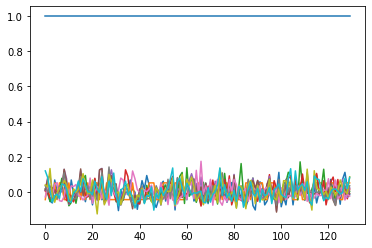

In [161]:
Xs_train, ys_train, X_test, y_test = get_data(n_clients=n_clients)


## prepare the data

# Introduction to ML
- data, mnistfashion or other
- simple model
- privacy. give examples: (personal data, phone/e-mail data, healthcare data etc)
# show an image on classical ML
# privacy issues
# explain the concept of FL
# FL challenges (performance and privacy, amount of data, trust of the algorithm if not seen, trust of the data of others etc
This very much differs on the use case. The first article (give reference, google) describing the concept of FL was provided by Google for their usecase. A lot of phone users write their messages and it would be great to be able to suggest to them the rest of the message. It can be very personal what you write so the suggestion should be personalized, but you most likely won't provide enough data to train the deep learnig algorithm. On the other side it would be a security breach if all the messages, from all the phones were send to the single server for training. Google proposed that the model will be trained on each phone for one or more epochs and then the model, not the data will be send to the centralized location. This could be for example weights. In the centralized location the server then combines those weights, for example averages them and sends back to each of the phones. Those updated weights they then use for further training.

In Owkin the use case is very different. The clients or sites are only very few but they have much larger data. The data is usually very sensitive and no information can leave the site. Nobody should even know how much of the data is on which site. You won't be able to check if it is well preprocessed or for the missing data so as you imagine it comes with additional challenges and I suppose, in all cases, some trust.

Another challenge is a performance. The bottleneck of FL is communication: sending the model back and fourth and waiting until the processing is finished. Especially if the model is very big, and even more so if there are a lot of sites.




# so let's now imagine...

## update our model to fl settings

In [14]:
import copy

model = NeuralNetwork()
learning_rate = 0.1
# optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()

def train(model, dataloader):
    # note: this is very simplified and won't work with every optimizer
    optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
    running_loss = 0.0
    for i, data in enumerate(dataloader, 0):
        num_batches = len(dataloader)
        # get the inputs; data is a list of [inputs, labels]
        image, label = data
        if image.shape[0] < 64:
            continue

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(image)
        loss = criterion(outputs, label)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % batch_size == batch_size-1:
            #print(loss.item())
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / batch_size))
            running_loss = 0.0
    return model


def avg_weights(weight1, weight2, weight3):
    
    mean_weights = []
    for w1, w2, w3 in zip(weight1, weight2, weight3):
        next_weight = (w1 + w2 + w3) / 3
        #next_weight = torch.mean(w1, w2, w3)
        # loop through all the weights
        #for i in range(1, len(weights)):
        #    next_weight += weight
        #next_weigth /= idx
        mean_weights.append(next_weight)
    return mean_weights
    

def get_weights(model):
    return model.parameters()

def set_weights(model, new_weights):
    with torch.no_grad():
        for param, new_param in zip(model.parameters(), new_weights):
            param.data[:] = new_param.data
    return model
    
n_epochs = 5
for epoch in range(n_epochs):  # loop over the dataset multiple times
    
    # train on site1
    # beta = 0.5 #The interpolation parameter
    '''
    params1 = model1.named_parameters()
    params2 = model2.named_parameters()

    dict_params2 = dict(params2)

    for name1, param1 in params1:
        if name1 in dict_params2:
            dict_params2[name1].data.copy_(beta*param1.data + (1-beta)*dict_params2[name1].data)

     model.load_state_dict(dict_params2)
    ''' 
    
    model1 = train(copy.deepcopy(model), site1_dataloader)
    model2 = train(copy.deepcopy(model), site2_dataloader)
    model3 = train(copy.deepcopy(model), site3_dataloader)

    params_m1 = get_weights(model1)
    params_m2 = get_weights(model2)
    params_m3 = get_weights(model3)
    
    mean_weights = avg_weights(params_m1, params_m2, params_m3)
    
    model = set_weights(model, mean_weights)
    print('continue to epoch, ', epoch)
    
print('Finished Training')

[1,    64] loss: 1.792
[1,   128] loss: 1.002
[1,   192] loss: 0.820
[1,   256] loss: 0.731
[1,   320] loss: 0.673
[1,   384] loss: 0.660
[1,   448] loss: 0.640
[1,    64] loss: 1.826
[1,   128] loss: 1.030
[1,    64] loss: 1.792
[1,   128] loss: 1.005
[1,   192] loss: 0.824
[1,   256] loss: 0.731
continue to epoch,  0
[2,    64] loss: 0.642
[2,   128] loss: 0.635
[2,   192] loss: 0.612
[2,   256] loss: 0.583
[2,   320] loss: 0.560
[2,   384] loss: 0.535
[2,   448] loss: 0.547
[2,    64] loss: 0.665
[2,   128] loss: 0.633
[2,    64] loss: 0.646
[2,   128] loss: 0.633
[2,   192] loss: 0.608
[2,   256] loss: 0.567
continue to epoch,  1
[3,    64] loss: 0.544
[3,   128] loss: 0.519
[3,   192] loss: 0.527
[3,   256] loss: 0.524
[3,   320] loss: 0.503
[3,   384] loss: 0.511
[3,   448] loss: 0.508
[3,    64] loss: 0.536
[3,   128] loss: 0.539
[3,    64] loss: 0.548
[3,   128] loss: 0.537
[3,   192] loss: 0.529
[3,   256] loss: 0.502
continue to epoch,  2
[4,    64] loss: 0.491
[4,   128] los

In [15]:
# predict
prediction = predict_model(model, test_dataloader)
accuracy, loss = get_score(test_dataloader, prediction)

print('accuracy is:', accuracy)
print('loss is:', loss)

accuracy is: 84.11
loss is: 0.4432794171723591


## Security

## hacking federated learning
If we just left the model as it is it would have been easy to hack on the model.

Now we will use slightly different data for site1 and site2

In [16]:
import torchvision as torchvision
import torch.utils.data.sampler as sampler
def get_indices(dataset, class_name):
    indices =  []
    for i in range(len(dataset.dataset.targets)):
        if dataset.dataset.targets[i] in class_name:
            indices.append(i)
    return indices


#dataset = torchvision.datasets.CIFAR10(root='./data',
#                           transform=torchvision.transforms.ToTensor())

idx = get_indices(site1, [0, 1, 2])
site1_newloader = DataLoader(training_data, batch_size=64, sampler=sampler.SubsetRandomSampler(idx))

# idx = get_indices(site2, [5, 6])
# site2_newloader = DataLoader(site2, batch_size=64, sampler=sampler.SubsetRandomSampler(idx))

for idx, (data, target) in enumerate(site1_newloader):
    pass
print(idx, target)
# for idx, (data, target) in enumerate(site2_newloader):
#    print(idx, target)

281 tensor([2, 2, 1, 1, 1, 1, 1, 0, 2, 2, 2, 1, 2, 0, 0, 2])


In [17]:
model1 = train(copy.deepcopy(model), site1_newloader)


[5,    64] loss: 0.137
[5,   128] loss: 0.119
[5,   192] loss: 0.119
[5,   256] loss: 0.099


In [18]:
#image, label = len(training_data)
idx = 0

*_, last_m1 = model1.parameters() # for a better understanding check PEP 448
*_, last_m = model.parameters() 
# print(last)


for idx, weight in enumerate(last_m1 - last_m):
    # m = m1.data - m2.data
    #if idx == 5:
    #    print(m1, m2)
    #    print(m)
    if weight > 0:
        print(idx, ':', classes[idx])
    #if i > 3:
    #    break
    # print(v.detach().numpy().shape)
    #plt.imshow(v.detach().numpy())
    # to view predicted labels uncomment following lines:
    # print('predicted:', pred.argmax(1))
    # print('true:',label)
    #if(v != 0):
    #     print(vocab[i])
    idx += 1

0 : t-shirt
1 : Trouser
2 : Pullover


So in fact we don't want the 

Explain secure aggregation

- adding noise (more secure but could harm performance)
- so aggregate in a way that nobody can view the weights of others
- so how could we do that? use homomorphic encryption



## What is homomorphic encryption

homomorphic encryption: gives possibility to perform some computations on encrypted values without decrypting them

First, a public key lets you encrypt numbers. A private key lets you decrypt
encrypted numbers. An encrypted value is called a ciphertext, and an unencrypted value
is called a plaintext. 

phe library? or something used in Substra?
give some resources

Now, let’s return to the problem of secure aggregation. Given your new knowledge that
you can add together numbers you can’t see, the answer becomes plain. The person who
initializes the model sends a public_key to Bob, Alice, and Sue so they can each encrypt
their weight updates

Then, Bob, Alice, and Sue (who don’t have the private key) talk directly
to each other and accumulate all their gradients into a single, final update that’s sent back to
the model owner, who decrypts it with the private_key.

In substra: Encryption function using python's pre-installed packages HMAC and hashlib.
    We are using SHA256 (it is equal in security to SHA512)
    scaffold (??)

In [19]:
'''
model = Embedding(vocab_size=len(vocab), dim=1)
model.weight.data *= 0

# note that in production the n_length should be at least 1024
public_key, private_key = phe.generate_paillier_keypair(n_length=128)

def train_and_encrypt(model, input, target, pubkey):
    new_model = train(copy.deepcopy(model), input, target, iterations=1)

    encrypted_weights = list()
    for val in new_model.weight.data[:,0]:
        encrypted_weights.append(public_key.encrypt(val))
    ew = np.array(encrypted_weights).reshape(new_model.weight.data.shape)
    
    return ew
'''

'\nmodel = Embedding(vocab_size=len(vocab), dim=1)\nmodel.weight.data *= 0\n\n# note that in production the n_length should be at least 1024\npublic_key, private_key = phe.generate_paillier_keypair(n_length=128)\n\ndef train_and_encrypt(model, input, target, pubkey):\n    new_model = train(copy.deepcopy(model), input, target, iterations=1)\n\n    encrypted_weights = list()\n    for val in new_model.weight.data[:,0]:\n        encrypted_weights.append(public_key.encrypt(val))\n    ew = np.array(encrypted_weights).reshape(new_model.weight.data.shape)\n    \n    return ew\n'

In [20]:
'''
# enable encrypting

import syft.frameworks.tenseal as ts

# hook PyTorch to add extra functionalities like the ability to encrypt torch tensors
hook = sy.TorchHook(th)
'''

'\n# enable encrypting\n\nimport syft.frameworks.tenseal as ts\n\n# hook PyTorch to add extra functionalities like the ability to encrypt torch tensors\nhook = sy.TorchHook(th)\n'

In [21]:
import phe

import syft as sy

# hook PyTorch to add extra functionalities like the ability to encrypt torch tensors
hook = sy.TorchHook(torch)

model = NeuralNetwork()
learning_rate = 0.1
criterion = nn.CrossEntropyLoss()

# this should be more secure for production
public_key, private_key = phe.generate_paillier_keypair(n_length=128)

def train_and_encrypt(model, dataloader, public_key):
    # note: this is very simplified and won't work with every optimizer
    
    new_model = train(copy.deepcopy(model), dataloader)
    
    encrypted_layers = list()
    for val in new_model.parameters():
        encrypted_weights = list()
        # matrix_encrypted = val.data.encrypt("ckks", public_key=public_keys)
        # data = val.data[:,0]
        # print(val.data[:,0])
        # print('vs', val.data)
        for num in val:
            print(num)
            encrypted_weights.append(public_key.encrypt(num))
        enc_weights = np.array(encrypted_layers).reshape(new_model.weight.data.shape)
        encrypted_layers.append(encrypted_weights)
    
    return enc_weights


def avg_weights(weight1, weight2, weight3):
    
    mean_weights = []
    weight1 + weight2 + weight3
    for w1, w2, w3 in zip(weight1, weight2, weight3):
        next_weight = (w1 + w2 + w3) / 3
        mean_weights.append(next_weight)
    return mean_weights
    

def get_weights(model):
    return model.parameters()

def set_weights(model, new_weights):
    with torch.no_grad():
        for param, new_param in zip(model.parameters(), new_weights):
            param.data[:] = new_param.data
    return model
    
n_epochs = 5
for epoch in range(n_epochs):  # loop over the dataset multiple times
    
    w1 = train_and_encrypt(copy.deepcopy(model), site1_dataloader, public_key)
    w2 = train_and_encrypt(copy.deepcopy(model), site2_dataloader, public_key)
    w3 = train_and_encrypt(copy.deepcopy(model), site3_dataloader, public_key)

    
    mean_weights = avg_weights(w1, w2, w3)
    
    model = set_weights(model, mean_weights)
    print('continue to epoch, ', epoch)
    
print('Finished Training')

ModuleNotFoundError: No module named 'phe'

other concepts:  federated learning,
homomorphic encryption, differential privacy, and secure multi-party computation are all
built in 

Two words about Substra and Connect

different strategies

two words about Connectlib

## Resources <a class="anchor" id="resources"></a>

**This work is based and inspired by existing resources:**
1. [`phe` Federated Learning example](https://github.com/data61/python-paillier/blob/master/examples/federated_learning_with_encryption.py)
1. (book, check out chapter on FL): Trask, A. W. (2019). Grokking deep learning. Simon and Schuster


**If you want to learn more on FL you can also refer to:**
1. 1st article on FL:
    [H. Brendan McMahan and Eider Moore and Daniel Ramage and Seth Hampson and Blaise Agüera y Arcas (2017) Communication-Efficient Learning of Deep Networks from Decentralized Data, arXiv1602.05629](https://arxiv.org/abs/1602.05629)
1. [Google blogpost on FL](https://ai.googleblog.com/2017/04/federated-learning-collaborative.html)
1. Old good [Wikipedia](https://en.wikipedia.org/wiki/Federated_learning)
